In [3]:
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, SeparableConv2D
from keras import Model
from keras.utils.vis_utils import plot_model

Let's import the train and test data into two dataframes. With the train data, we can partition 20% to be the validation set.

In [4]:
import math
train = pd.read_csv('train.csv')
print(train.shape)
x_train=train.values[:math.floor(train.shape[0]*(8/10)),1:]
x_val = train.values[math.floor(train.shape[0]*(8/10)):, 1:]
y_train = train.values[:math.floor(train.shape[0]*(8/10)), 0]
y_val = train.values[math.floor(train.shape[0]*(8/10)):, 0]
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
test = pd.read_csv('test.csv')
x_test=test.values[:,:]


(42000, 785)
(33600, 784) (8400, 784) (33600,) (8400,)


Normalize training, testing, and validation input data

In [5]:
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0  # customary normalization to [0, 1]
print('Train', x_train.min(), x_train.max(), x_train.mean(), x_train.std())
print('Test', x_test.min(), x_test.max(), x_test.mean(), x_test.std())
print('Val', x_val.min(), x_val.max(), x_val.mean(), x_val.std())
x_train_std = x_train.std()
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()
x_val = (x_val-x_val.mean())/x_val.std()

Train 0.0 1.0 0.13100810726076145 0.3085020559991234
Test 0.0 1.0 0.1307903729348881 0.3083109758728445
Val 0.0 1.0 0.13104426056136725 0.3086925069083743


Reshape x data from (42000, 784) -> (42000, 28, 28, 1) and use last 3 dimensions for input size (in_shape var)

In [6]:
x_dim = np.ceil(np.sqrt(x_train.shape[1])).astype(np.uint8)
x_train = tf.reshape(x_train, [-1, x_dim, x_dim,1])
x_test = tf.reshape(x_test, [-1, x_dim, x_dim,1])
x_val = tf.reshape(x_val, [-1, x_dim, x_dim,1])

Set shape of input and find number of unique values in y_train to be uses as units for last dense layer. Construct a CNN taking in input data of size (28,28,1) and output size of the number of unique values in in y_train, i.e., 10 in this case data has 10 unique labels (numbers 1-9).

In [7]:
from tensorflow.keras import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout, MaxPool2D, Input
from keras import Model
from numpy import unique

# # determine the shape of the input images
in_shape = x_train.shape[1:]

# # determine the number of classes
n_classes = len(unique(y_train))



input_layer = Input(in_shape)
conv_1 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(conv_1)
pool_1 = MaxPool2D(2)(conv_2)
conv_3 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool_1)
conv_4 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(conv_3)
pool_2 = MaxPool2D(2)(conv_4)
flat = Flatten()(pool_2)
dense_1 = Dense(64, activation="relu")(flat)
output = Dense(n_classes, activation='softmax')(dense_1)
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',  # pick an optimizer
                     loss='sparse_categorical_crossentropy',  # pick a loss
                     metrics=['accuracy'])  # pick a metric to monitor

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        3216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

Define a graph function to plot how our network performs over time (accuracy vs time (epoch))

In [8]:
def graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

fit the model

In [9]:
history = model.fit(x_train, y_train,
              epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1050/1050 [==============================] - 46s 44ms/step - loss: 0.1742 - accuracy: 0.9446 - val_loss: 0.0751 - val_accuracy: 0.9760
Epoch 2/10
1050/1050 [==============================] - 44s 42ms/step - loss: 0.0496 - accuracy: 0.9849 - val_loss: 0.0385 - val_accuracy: 0.9869
Epoch 3/10
1050/1050 [==============================] - 44s 42ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0447 - val_accuracy: 0.9870
Epoch 4/10
1050/1050 [==============================] - 45s 43ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0440 - val_accuracy: 0.9886
Epoch 5/10
1050/1050 [==============================] - 45s 43ms/step - loss: 0.0209 - accuracy: 0.9929 - val_loss: 0.0416 - val_accuracy: 0.9898
Epoch 6/10
1050/1050 [==============================] - 46s 44ms/step - loss: 0.0176 - accuracy: 0.9945 - val_loss: 0.0435 - val_accuracy: 0.9886
Epoch 7/10
1050/1050 [==============================] - 44s 42ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0445 -

plot the history

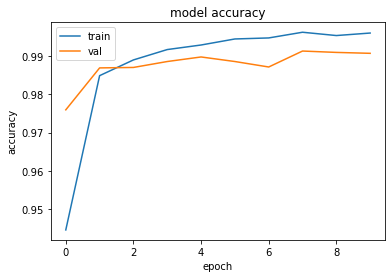

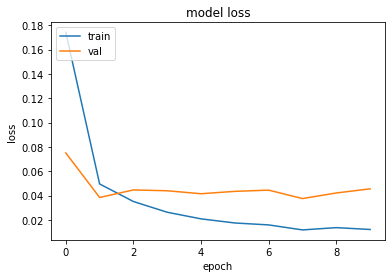

In [10]:
graph(history)

make a prediction

In [11]:
preds = model.predict(x_test).argmax(axis=1)

put prediction in dataframe and make a column for "ImageID" given the submission requirements

In [12]:
sub = pd.DataFrame(preds, columns=["Label"])
image_id = [x for x in range(preds.shape[0]+1)]
sub.insert(0, "ImageID", image_id[1:])
print(sub)

       ImageID  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


expot dataframe to csv

In [13]:
sub.to_csv("submission.csv",index=False)

In [14]:
sub

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
